# AI-LAB EXAM 2019

### Delivery instructions
Send an email with this notebook attached where:
* Recipient: alessandro.farinelli@univr.it
* Carbon copy (CC): riccardo.sartea@univr.it
* Subjet: AI Exam 2019 - Matricola, Name Surname
* Body: Matricola, Name Surname
* Attachment: this notebook **renamed as MATRICOLA.ipynb**. To rename the notebook click on the top-left of the browser tab (on "Exam2019") and insert the new name

Every cell must run without errors when executing the notebook from top to bottom. If this is not the case, your exam may be invalidated. **Do not forget to answer the question in each assignment!**. Also, **do not forget to save the notebook! (CTRL+S)**

## Windy Gridworld environment

The environment to use for this exam is **WindyGridworld** (taken from the book of Sutton and Barto)
![WindyGridworld](images/WindyGridworld.png)

The agent starts in cell $(3, 0)$ and has to reach the goal in $(3, 7)$. All cells are safe but there is a crosswind running upward through the middle of the grid. The available actions are:
* *U*: 0
* *R*: 1
* *D*: 2
* *L*: 3

but in the middle region the resultant next states are shifted upward by a *wind* the strength of which varies from column to column (visible at the bottom of each column in the figure). For example if the agent is in position $(3, 8)$, then action *Left* would move it to position $(2, 7)$. Going *Down* from position $(1, 6)$ would move the agent to position $(0, 6)$ instead.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
import envs
import numpy as np
import utils.heuristics as heu
from utils.fringe import FringeNode, PriorityFringe, QueueFringe
from utils.funcs import plot, build_path
from timeit import default_timer as timer

# Assignment 1

Assuming the agent has full knowledge of the environment, find the optimal path from the agent starting position to the goal with an uninformed or informed search algorithm of your choice. Suppose a step cost of 1 for any action. You have to show the result as a tuple $(path, stats)$ in the following form:
* *path* - tuple of state identifiers forming a path from the start state to the goal state. ``None`` if no solution is found
* *stats* - tuple of:
     * *time* - time elapsed between the start and the end of the algorithm
     * *expc* - number of nodes explored. A node is considered as explored when it is analyzed (state goal check, expansion, etc.)
     * *maxnodes* - maximum number of nodes in memory at the same time
     
Insert the function/s defining your algorithm of choice in the next cell

In [29]:
### INSERT YOUR ALGORITHM HERE ###
def graph_search(environment, fringe):
    """
    Graph search

    Args:
        environment: OpenAI Gym environment
        fringe: instance of Fringe data structure

    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (expc, maxnodes): number of explored nodes, max nodes in memory
    """
    closed = set()
    max_nodes = 0
    explored_states = 0

    fringe.add(FringeNode(environment.startstate))
    while not fringe.is_empty():
        node = fringe.remove()
        if node.state in closed:
            continue
        explored_states += 1
        closed.add(node.state)
        if len(closed) > max_nodes:
            max_nodes = len(closed)
        if node.state == environment.goalstate:
            return build_path(node), (explored_states, max_nodes)
        for action in range(environment.action_space.n):
            successor = FringeNode(state=environment.sample(node.state, action), parent=node)
            fringe.add(successor)

    return None, (explored_states, max_nodes)


def bfs(environment):
    """
    Breadth-first search
    
    Args:
        environment: OpenAI Gym environment
        search_type: type of search - tree_search or graph_search (function pointer)
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    path, stats = graph_search(environment, QueueFringe())
    return path, (timer() - t, stats[0], stats[1])


def astar_graph_search(environment):
    """
    A* Graph search
    
    Args:
        environment: OpenAI Gym environment
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (expc, maxnodes): number of explored nodes, max nodes in memory
    """
    expc = 0
    maxnodes = 0
    closed = set()
    fringe = PriorityFringe()
    node_position = environment.state_to_pos(environment.startstate)
    goal_position = environment.state_to_pos(environment.goalstate)
    h = heu.l1_norm(goal_position, node_position)
    fringe.add(FringeNode(environment.startstate, pathcost=0, value=h))
    
    while True:
        if fringe.is_empty():
            return None, (expc, maxnodes + 1)
        node = fringe.remove()  # Retrieve node from the fringe
        expc += 1
        if len(closed) + len(fringe) > maxnodes:
            maxnodes = len(closed) + len(fringe)
        if node.state in closed:
            continue
        closed.add(node.state)
        if node.state == environment.goalstate:  # Goal state check
            return build_path(node), (expc, maxnodes + 1)
        for action in range(environment.action_space.n):  # Look around
            child = FringeNode(environment.sample(node.state, action), node)
            node_position = environment.state_to_pos(child.state)
            h = heu.l1_norm(goal_position, node_position)
            child.pathcost = node.pathcost + 1
            child.value = h + child.pathcost
            fringe.add(child)


def astar(environment):
    """
    A* search
    
    Args:
        environment: OpenAI Gym environment
        search_type: type of search - astar_tree_search or astar_graph_search (function pointer)
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    path, stats = astar_graph_search(environment)
    return path, (timer() - t, stats[0], stats[1])


def greedy_graph_search(environment):
    """
    Greedy-best-first Graph search
    
    Args:
        environment: OpenAI Gym environment
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (expc, maxnodes): number of explored nodes, max nodes in memory
    """
    expc = 0
    maxnodes = 0
    closed = set()
    fringe = PriorityFringe()
    node_position = environment.state_to_pos(environment.startstate)
    goal_position = environment.state_to_pos(environment.goalstate)
    h = heu.l1_norm(goal_position, node_position)
    fringe.add(FringeNode(environment.startstate, value=h))
    
    while True:
        if fringe.is_empty():
            return None, (expc, maxnodes)
        node = fringe.remove()  # Retrieve node from the fringe
        expc += 1
        if node.state in closed:
            continue
        closed.add(node.state)
        if len(closed) + len(fringe) > maxnodes:
            maxnodes = len(closed) + len(fringe)
        if node.state == environment.goalstate:  # Goal state check
            return build_path(node), (expc, maxnodes)
        for action in range(environment.action_space.n):  # Look around
            child = FringeNode(environment.sample(node.state, action), node)
            node_position = environment.state_to_pos(child.state)
            h = heu.l1_norm(goal_position, node_position)
            child.value = h
            fringe.add(child)


def greedy(environment):
    """
    Greedy-best-first search
    
    Args:
        environment: OpenAI Gym environment
        search_type: type of search - greedy_tree_search or greedy_graph_search (function pointer)
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    path, stats = greedy_graph_search(environment)
    return path, (timer() - t, stats[0], stats[1])


def dls_gs(environment, limit):
    """
    Depth-limited search (graph search)
    
    Args:
        environment: OpenAI Gym environment
        limit: depth limit budget
        
    Returns:
        (path, cutoff, stats): solution as a path, cutoff flag and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    path, cutoff, expc, maxdepth = rdls_gs(environment, FringeNode(environment.startstate), limit, set())
    return path, cutoff, (timer() - t, expc, maxdepth)


def rdls_gs(environment, node, limit, closed):
    """
    Recursive depth-limited search (graph search)
    
    Args:
        environment: OpenAI Gym environment
        node: node to explore
        limit: depth limit budget
        closed: completely explored nodes
        
    Returns:
        (path, cutoff, expc, maxdepth): path, cutoff flag, n° of nodes explored, max nodes in memory
    """
    explored_states = 0
    closed.add(node.state)
    parent_cutoff = False 
    if node.state == environment.goalstate:
        return build_path(node), False, 1, limit
    if limit == 0:
        return None, True, 1, limit
    for action in range(environment.action_space.n):
        successor = FringeNode(environment.sample(node.state, action), parent=node)
        if successor.state in closed:
            continue
        result, cutoff, expc, maxdepth = rdls_gs(environment, successor, limit - 1, closed)
        explored_states += expc
        if not cutoff and result is not None:
            return result, cutoff, explored_states + 1, limit + 1
        if cutoff:
            parent_cutoff = True
    return None, parent_cutoff, explored_states + 1, limit + 1


def ids(environment, search_type):
    """
    Iterative deepening depth-first search
    
    Args:
        environment: OpenAI Gym environment
        search_type: type of search (graph or tree) - dls_gs or dls_ts (function pointer)
    
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    # Pseudocode
    # for depth = 0 to infinity
    #   solution, cutoff, stats = stype(problem, depth)
    depth = 0
    expc = 0
    while True:
        result, cutoff, stats = search_type(environment, depth)
        expc += stats[1]
        if result is None and not cutoff:
            return None, (timer() - t, expc, stats[2])
        elif not cutoff:
            return result, (timer() - t, expc, stats[2])
        depth += 1


Insert the code to execute your algorithm and to show the result in the next cell

In [31]:
envname = "WindyGridworld-v0"

# Create and render the environment
env = gym.make(envname)
env.render()

solution, stats = bfs(env)  # Perform BFS
if solution is not None:
    solution = [env.state_to_pos(s) for s in solution]

# Print stats and path
print("\n\nBFS:\nExecution time: {0}s\nN° of nodes explored: {1}\nMax n° of nodes in memory: {2}\nSolution: {3}".format(
        round(stats[0], 4), stats[1], stats[2], solution))

solution, stats = ids(env, dls_gs)  # Perform BFS
if solution is not None:
    solution = [env.state_to_pos(s) for s in solution]
    
# Print stats and path
print("\n\nIDS:\nExecution time: {0}s\nN° of nodes explored: {1}\nMax n° of nodes in memory: {2}\nSolution: {3}".format(
        round(stats[0], 4), stats[1], stats[2], solution))

solution, stats = astar(env)  # Perform A* search
if solution is not None:
    solution = [env.state_to_pos(s) for s in solution]
    
# Print stats and path
print("\n\nASTAR:\nExecution time: {0}s\nN° of nodes explored: {1}\nMax n° of nodes in memory: {2}\nSolution: {3}".format(
        round(stats[0], 4), stats[1], stats[2], solution))

solution, stats = greedy(env)  # Perform Greedy-best-first search
if solution is not None:
    solution = [env.state_to_pos(s) for s in solution]
    
# Print stats and path
print("\n\nGREEDY:\nExecution time: {0}s\nN° of nodes explored: {1}\nMax n° of nodes in memory: {2}\nSolution: {3}".format(
        round(stats[0], 4), stats[1], stats[2], solution))


o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



BFS:
Execution time: 0.0243s
N° of nodes explored: 60
Max n° of nodes in memory: 60
Solution: [(3, 1), (3, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


IDS:
Execution time: 0.0773s
N° of nodes explored: 621
Max n° of nodes in memory: 19
Solution: [(2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


ASTAR:
Execution time: 0.0246s
N° of nodes explored: 210
Max n° of nodes in memory: 86
Solution: [(3, 1), (3, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


GREEDY:
Execution time: 0.0096s
N° of nodes explored: 42
Max n° of nodes in memory: 65
Solution: [(3, 1), (3, 2), (

## Question

Motivate your choice for the algorithm used. Focus only on optimality guarantees and stats (do not worry about exact numbers for the stats, just the trend). Consider both *tree search* and *graph search* variants in your motivation

## Answer

--------- INSERT ANSWER HERE!!!!!!! ---------
Come si può vedere dalle statistiche, in questo caso è preferibile BFS con graph search per una ricerca non informata, oppure Greedy best-first search (+ graph search) per una ricerca informata. 
Questo perché la BFS è ottima con step cost uniforme, ed è migliore di IDS poiché non attraversa più volte gli stessi stati, ma li visita una volta sola, arrivando direttamente al goal, e Greedy poiché una soluzione "golosa" in questo caso porta direttamente al risultato, senza esplorare nodi che hanno come funzione totale, euristica+costo, ma considera solamente l'euristica (in questo caso l1_norm, cioè la manhattan distance). 

Bisogna però considerare che Greedy di per sè non è ottimo come algoritmo, quindi in generale non garantisce di trovare sempre la soluzione ottima. In questo caso funziona poiché l'euristica ammissibile, permette di arrivare direttamente al goal e più velocemente (quindi esplorando un numero inferiore di stati), senza perdersi in eventuali cicli grazie alla closed (graph search) che evita di esplorare nuovamente stati già visitati precedentemente.

# Assignment 2

Consider the **WindyGridworld** environment defined above. Assume the reward is:

* <span style="color:red">-1</span> for every step

and the episode ends only when the goal state is reached. The action dynamics are deterministic, but the agent has no prior knowledge of the environment (there is no $T$ or $R$ function avaible for use unless the agent creates them online). It is possible however to sample the next state given the current state and an action with *sample(state, action)* (again, with a deterministic result).

Find the policies for the **WindyGridworld** environment by using *Q-Learning* ($\epsilon$-greedy) and *SARSA* ($\epsilon$-greedy) reinforcement learning algorithms. The solution returned must be a tuple *(policy, episodes)* where:
* *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
* *episodes*: array of cumulative episodes where the $i$-th value refers to cumulative number of episodes **completed** up to the $i$-th step. Example: if you execute a total number of 10 steps and your agent completes an episode after 4 steps and another one after 9, the $episodes$ array will look like this: $[0, 0, 0, 1, 1, 1, 1, 1, 2, 2]$. This means that the first episodes length is $4$ whether the second episode length is $5$.

The code used to call your algorithms is already inserted below, therefore, **pay attention to the interface (input/output) of the functions to implement!!!** In particular, **the agent is given a total number of steps to do, not a total number of episodes!!!**. Hence, if the parameter *steps* is $100$, the agent must stop after $100$ steps, regardless of how many episodes have been completed.

Insert the $\epsilon$-greedy function in the next cell

In [36]:
def epsilon_greedy(q, state, epsilon):
    """
    Epsilon-greedy action selection function
    
    Args:
        q: q table
        state: agent's current state
        epsilon: epsilon parameter
    
    Returns:
        action id
    """
    actions = len(q[0])
    if np.random.choice(2, p=[1-epsilon, epsilon]) == 1:
        return np.random.randint(0, actions)
    
    return np.argmax(q[state])  # best action


Insert your *Q-Learning* algorithm implementation in the following cell

In [118]:
def q_learning(environment, steps, alpha, gamma, epsilon):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        steps: number of steps for training
        alpha: alpha parameter
        gamma: gamma parameter
        epsilon: exploration paramenter for epsilon-greedy
    
    Returns:
        (policy, episodes): final policy, cumulative number of episodes completed at each step [array]
    """
    episodes = np.zeros(steps)
    ep_finished = 0
    q = np.zeros((environment.observation_space.n, environment.action_space.n))
    s = environment.reset()

    for step in range(steps):
        a = epsilon_greedy(q, s, epsilon)
        s1, r, done, _ = environment.step(a)
        q[s, a] += alpha * (r + gamma*np.max(q[s1], axis=0) - q[s, a])
        s = s1
        if done:
            ep_finished += 1
            s = environment.reset()
        
        episodes[step] = ep_finished

    policy = np.random.choice(environment.action_space.n, environment.observation_space.n)  # Random policy
    for state in range(environment.observation_space.n):
        policy[state] = np.argmax(q[state])

    return policy, episodes


Insert your *SARSA* algorithm implementation in the next cell

In [119]:
def sarsa(environment, steps, alpha, gamma, epsilon):
    """
    Performs the SARSA algorithm for a specific environment
    
    Args:
        environment: OpenAI gym environment
        steps: number of steps for training
        alpha: alpha parameter
        gamma: gamma parameter
        epsilon: exploration paramenter for epsilon-greedy
    
    Returns:
        (policy, episodes): final policy, cumulative number of episodes completed at each step [array]
    """
    episodes = np.zeros(steps)
    ep_finished = 0
    q = np.zeros((environment.observation_space.n, environment.action_space.n))
    s = environment.reset()
    a = epsilon_greedy(q, s, epsilon)
    for step in range(steps):

        s1, r, done, _ = environment.step(a)
        a1 = epsilon_greedy(q, s1, epsilon)
        q[s, a] += alpha*(r + gamma*q[s1, a1] - q[s, a])
        s = s1
        a = a1
        if done:
            ep_finished += 1
            s = environment.reset()

        episodes[step] = ep_finished

    policy = np.random.choice(environment.action_space.n, environment.observation_space.n)  # Random policy
    for state in range(environment.observation_space.n):
        policy[state] = np.argmax(q[state])

    return policy, episodes


The following code executes your two algorithms and plots a chart with the behavior of the agent in time


----------------------------------------------------------------
	Environment:  WindyGridworld-v0
----------------------------------------------------------------

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o




Q-Learning
Execution time: 0.7641s
Policy:
[['L' 'U' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'U' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'U' 'U' 'D' 'L' 'L']
 ['U' 'L' 'R' 'R' 'R' 'U' 'U' 'U' 'L' 'D']
 ['L' 'R' 'R' 'R' 'U' 'U' 'U' 'U' 'D' 'R']]



SARSA
Execution time: 1.1994s
Policy:
[['U' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'U' 'R' 'R' 'U' 'R' 'R' 'U' 'R' 'D']
 ['R' 'D' 'R' 'R' 'R' 'R' 'D' 'U' 'R' 'D']
 ['D' 'R' 'R' 'R' 'R' 'L' 'R' 'U' 'R' 'D']
 ['R' 'R' 'R' 'R' 'D' 'R' 'U' 'D' 'L' 'L']
 ['R' 'R' 'D' 'D' 'R' 'U' 'U' 'D' 'L' 'D']
 ['D' 'R' 'L' 'R' 'U' 'U' 'U' 'U' 'U' 'U']]



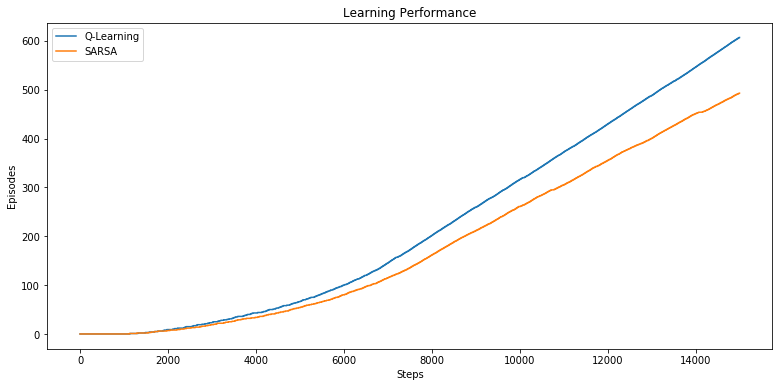

In [120]:
envname = "WindyGridworld-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()
print()

# Learning parameters
steps = 15000
alpha = .5
gamma = .9
delta = 1e-3
epsilon = .1

t = timer()

# Q-Learning epsilon greedy
policy, episodes = q_learning(env, steps, alpha, gamma, epsilon)
print("Q-Learning\nExecution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
q_learning_series = {"x": np.arange(steps), "y": episodes, "label": "Q-Learning"}

# SARSA epsilon greedy
policy, episodes = sarsa(env, steps, alpha, gamma, epsilon)
print("SARSA\nExecution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
sarsa_series = {"x": np.arange(steps), "y": episodes, "label": "SARSA"}
plot([q_learning_series, sarsa_series], "Learning Performance", "Steps", "Episodes")

## Question

Explain the differences in the learning performance between the two algorithms by explicitly referring to the chart above

## Answer

--------- INSERT ANSWER HERE!!!!!!! ---------